<a href="https://colab.research.google.com/github/rachit2005/Transformer/blob/main/transformer(attention_is_all_you_need).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dmodel = 512 --> in paper , it represents the size of the embedding vector of each word

Input Embedding --> the process of converting input text (words or subwords) into numerical vectors, capturing their semantic meaning

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch
from torch import nn
import math

class InputEmbedding(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model) # given in paper under Embedding and Softmax title

Positional Embedding --> a technique used to inject information about the position of words in a sequence into the model's architecture

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self , d_model,seq_length , dropout):
    super().__init__()
    self.d_model = d_model
    self.seq_length = seq_length
    self.dropout = nn.Dropout(p=dropout)

    # create a matrix of shape (seq_length , d_model)
    pe = torch.zeros(seq_length ,d_model)
    # create a vector which represent the position of the word in the sentence
    position = torch.arange(0,seq_length, dtype=torch.float).unsqueeze(1) # --> shape : [seq_length , 1]
    div_term = torch.exp(torch.arange(0 , d_model , 2).float()*(-math.log(10000)/d_model)) # --> shape : [d_model/2]
    # apply the sin to even pos and cos to odd pos
    pe[:,0::2] = torch.sin(position * div_term) # --> all the columns with rows from 0 with step of 2
    pe[:,1::2] = torch.cos(position * div_term)

    # now we add the batch dimension to apply to whole sentences
    pe = pe.unsqueeze(0) # --> shape: [1,seq_length , d_model]
    self.register_buffer('pe' , pe)

  def forward(self , x):
    # x.shape --> [batch_size, seq_length, d_model]
    x = x + (self.pe[: , :x.shape[1] , :]).requires_grad_(False)
    return self.dropout(x)


Layer Normalization --> normalization technique like batch normalization

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self , epsilon:float = 10**-6):
    super().__init__()
    self.eps = epsilon
    # nn.Parameter --> it is a special tensor that tells the model that it is a learnable parameter
    self.gamma = nn.Parameter(torch.ones(1))
    self.beta = nn.Parameter(torch.zeros(1))

  def forward(self , x):
    mean = x.mean(dim=-1 , keepdim=True)
    std = x.std(dim=-1 , keepdim=True)

    gamma = self.gamma.to(x.device)
    beta = self.beta.to(x.device)

    return gamma*(x-mean)/(std + self.eps) + beta

Feed Forward Layer --> This consists of two linear transformations(W1 , W2 , b1 , b2) with a ReLU activation(max-function) in between.

FFN(x) = max(0xW1 +b1)W2 +b2

and the first layer in from d_model to d_ff and then the other one is from d_ff to d_model

In [ ]:
class FeedForwardLayer(nn.Module):
  def __init__(self , d_model , d_ff , dropout):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(d_model , d_ff), # [batch , seq_length , d_model] --> [batch , seq_length , d_ff]
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(d_ff , d_model),# [batch , seq_length , d_ff] --> [batch , seq_length , d_model]
    )

  def forward(self , x):
    return self.feed_forward(x)

Multi-Head-Attention --> a mechanism that enhances the original attention mechanism by running it multiple times in parallel, each with its own learnable parameters.

please watch "https://www.youtube.com/watch?v=bCz4OMemCcA"

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self , d_model , h , dropout):
    super().__init__()
    self.d_model = d_model
    self.num_heads = h
    self.d_k = d_model // h
    self.dropout = nn.Dropout(p=dropout)
    assert d_model%h == 0

    self.w_q = nn.Linear(d_model , d_model)
    self.w_k = nn.Linear(d_model , d_model)
    self.w_v = nn.Linear(d_model , d_model)

    self.w_o = nn.Linear(h*self.d_k, d_model) # h*d_k == d_model

    self.dropout = nn.Dropout(p=dropout)

  @staticmethod
  def attention(query , key , value ,mask , dropout):
    d_k = query.shape[-1]
    # remember --> key shape: [batch , num_heads , seq_length , d_k] , after transpose --> [batch , num_heads , d_k ,seq_length]
    attention_scores = (query @ key.transpose(-2 , -1))/d_k**(0.5) # --> [batch , num_heads , seq_length,seq_length]
    if mask is not None:
      attention_scores.masked_fill_(mask==0 , -1e9)
    attention_scores = attention_scores.softmax(dim=-1)

    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return attention_scores @ value , attention_scores # --> shapes -> [batch , num_heads , seq_length , d_k] , [batch , num_heads , seq_length,seq_length]

  def forward(self, q,k,v, mask):
    # q.shape --> [batch , seq_length , d_model]
    query = self.w_q(q) # --> [batch , seq_length , d_model]
    key = self.w_k(k) # --> [batch , seq_length , d_model]
    value = self.w_v(v) # --> [batch , seq_length , d_model]

    # [batch , seq_length , d_model] --> [batch , seq_length , num_heads , d_k] --> [batch , num_heads , seq_length , d_k]
    query = query.view(query.shape[0] , query.shape[1] , self.num_heads , self.d_k).transpose(1,2)
    key = key.view(key.shape[0] , key.shape[1] , self.num_heads , self.d_k).transpose(1,2)
    value = value.view(value.shape[0] , value.shape[1] , self.num_heads , self.d_k).transpose(1,2)

    x , attention_scores = MultiheadAttention.attention(query , key , value , mask , self.dropout)

    # [batch , num_heads , seq_length , d_k] --> [batch , seq_length , num_heads , d_k] --> [batch , seq_length , d_model]
    x = x.transpose(1,2).contiguous().view(x.shape[0] , -1 , self.d_model)

    return self.w_o(x) # shape --> [batch , seq_length , d_model]

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self , dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x , sublayer):
    # sublayer is the prev layer
    return x + self.dropout(sublayer(self.norm(x)))

# Encoder

In a Transformer architecture, the encoder's key and value tensors are used by the decoder

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self ,self_attention_block:MultiheadAttention , feed_forward_block:FeedForwardLayer, dropout):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, mask):
    # first we do the self attention --> making the words intereact with each other in the same sentences
    x = self.residual_connections[0](x , lambda x: self.self_attention_block(x,x,x,mask))
    x = self.residual_connections[1](x , self.feed_forward_block)

    return x # now this will go to the decoder as key and value pair

In [ ]:
class Encoder(nn.Module):
  def __init__(self , layers:nn.Module):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x ,mask):
    for layer in self.layers:
      x = layer(x , mask)

    return self.norm(x)

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self , self_attention_block:MultiheadAttention , cross_attention_block:MultiheadAttention , feed_forward_block:FeedForwardLayer, dropout):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = [ResidualConnection(dropout) for _ in range(3)]

  def forward(self , x , encoder_output , encoder_mask,decoder_mask):
    x = self.residual_connections[0](x , lambda x: self.self_attention_block(x,x,x,decoder_mask))
    x = self.residual_connections[1](x , lambda x:self.cross_attention_block(x,encoder_output,encoder_output,encoder_mask)) # in this query will come from the masked multi-head-attention and the key and value will come from the encoder block output
    x = self.residual_connections[2](x , self.feed_forward_block)

    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self , layers:nn.Module):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x , encoder_output , encoder_mask , decoder_mask):
    for layer in self.layers:
      x = layer(x , encoder_output , encoder_mask , decoder_mask)

    return self.norm(x)

# we expect the output form decoder to be --> [batch , seq_length , d_model]

In [ ]:
# now we want to map these words into the vocabulary
class ProjectionLayer(nn.Module):
  def __init__(self , d_model , vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model , vocab_size)

  def forward(self , x):
    # x.shape --> [batch , seq_length , d_model]
    return torch.log_softmax(self.proj(x) ,dim=-1) # --> [batch , seq_length , vocab_size]

# Transformer Block  -->

In [ ]:
class Transformer(nn.Module):
  def __init__(self , encoder:Encoder , decoder:Decoder , src_emb:InputEmbedding , trg_emb:InputEmbedding , srcpos:PositionalEncoding , trgpos:PositionalEncoding , projection_layer:ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_emb = src_emb
    self.trg_emb = trg_emb
    self.srcpos = srcpos
    self.trgpos = trgpos
    self.projection_layer = projection_layer

  def encode(self , src , src_mask):
    src = self.srcpos(self.src_emb(src))
    return self.encoder(src , src_mask)

  def decode(self , trg , encoder_output , src_mask , trg_mask):
    trg = self.trgpos(self.trg_emb(trg))
    return self.decoder(trg , encoder_output , src_mask , trg_mask)

  def project(self , x):
    return self.projection_layer(x)

In [ ]:
def build_transformer(src_vocab_size , trg_vocab_size , src_seq_length , trg_seq_length , d_model , h , dropout , N , d_ff):
  # create embedding layer for source and target
  src_embed = InputEmbedding(d_model , src_vocab_size + 1).to(device)
  trg_embed = InputEmbedding(d_model , trg_vocab_size + 1).to(device)

  # create positional embedding layer
  src_pos = PositionalEncoding(d_model , src_seq_length , dropout).to(device)
  trg_pos = PositionalEncoding(d_model , trg_seq_length , dropout).to(device)

  # create encoder block
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiheadAttention(d_model , h , dropout).to(device)
    feed_forward_block = FeedForwardLayer(d_model , d_ff , dropout).to(device)
    encoder_blocks.append(EncoderBlock(encoder_self_attention_block , feed_forward_block , dropout))

  # create decoder block
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiheadAttention(d_model , h , dropout).to(device)
    decoder_cross_attention_block = MultiheadAttention(d_model , h , dropout).to(device)
    feed_forward_block = FeedForwardLayer(d_model , d_ff , dropout).to(device)
    decoder_blocks.append(DecoderBlock(decoder_self_attention_block , decoder_cross_attention_block , feed_forward_block , dropout))

  # create the encoder and decoder
  encoder = Encoder(encoder_blocks).to(device)
  decoder = Decoder(decoder_blocks).to(device)

  # create projection layer
  projection_layer = ProjectionLayer(d_model , trg_vocab_size).to(device)

  # create transformer
  transformer = Transformer(encoder , decoder , src_embed , trg_embed , src_pos , trg_pos , projection_layer).to(device)

  # initialize parameters using xavier_uniform_
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

In [ ]:
!wget -nc https://downloads.tatoeba.org/exports/sentences.tar.bz2
!wget -nc https://downloads.tatoeba.org/exports/links.tar.bz2
!tar -xf sentences.tar.bz2
!tar -xf links.tar.bz2


File ‘sentences.tar.bz2’ already there; not retrieving.

File ‘links.tar.bz2’ already there; not retrieving.



In [ ]:
import pandas as pd

df = pd.read_csv("sentences.csv", sep="\t", header=None, names=["id", "lang", "text"])
# print(df.head())

df_eng = df[df['lang']=='eng']
df_hindi = df[df['lang'] == 'hin']

# print(df_eng.head())
# print(df_hindi.head())

links = pd.read_csv('links.csv' , sep='\t' , header=None , names=["src" , "tgt"]) # loads the links bettwen the target
# print(links.head())

# Merge to get aligned pairs
merged = links.merge(df_eng, left_on="src", right_on="id").merge(df_hindi, left_on="tgt", right_on="id", suffixes=('_en', '_hi'))
print(merged.head())

en_sentences = merged['text_en'].tolist()
hi_sentences = merged['text_hi'].tolist()

print(f"Found {len(en_sentences)} English–Hindi sentence pairs")

    src      tgt  id_en lang_en                     text_en    id_hi lang_hi  \
0  1277  3792910   1277     eng      I have to go to sleep.  3792910     hin   
1  1282   485968   1282     eng          Muiriel is 20 now.   485968     hin   
2  1282  2060319   1282     eng          Muiriel is 20 now.  2060319     hin   
3  1283   451291   1283     eng  The password is "Muiriel".   451291     hin   
4  1283   451292   1283     eng  The password is "Muiriel".   451292     hin   

                            text_hi  
0                     मुझे सोना है।  
1  म्यूरियल अब बीस साल की हो गई है।  
2        म्यूरियल अब बीस साल की है।  
3              कूटशब्द "Muriel" है।  
4              पासवर्ड "Muriel" है।  
Found 13182 English–Hindi sentence pairs


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path


# converting the lines to txt file
with open("eng.txt" , "w") as f:
  for line in en_sentences:
    f.write(line.strip() + "\n")

with open("hindi.txt" , "w") as f:
  for line in hi_sentences:
    f.write(line.strip() + "\n")

In [ ]:
def train_tokenizer(file_path:Path , vocab_size:int , output_path:Path):
  tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
  tokenizer.pre_tokenizer = Whitespace()
  trainer = WordLevelTrainer(vocab_size=vocab_size , special_tokens=["[PAD]" , "[SOS]" , "[EOS]" , "[UNK]"] , min_frequency=2)
  tokenizer.train([file_path] , trainer)
  tokenizer.save(output_path)

train_tokenizer("eng.txt" , 8000 , "en-tokenize.json")
train_tokenizer("hindi.txt" , 8000 , "hindi-tokenize.json")

eng_tokenizer = Tokenizer.from_file("en-tokenize.json")
hindi_tokenizer = Tokenizer.from_file("hindi-tokenize.json")

VOCAB_SIZE_ENG = eng_tokenizer.get_vocab_size()     # 5912
VOCAB_SIZE_HINDI = hindi_tokenizer.get_vocab_size() # 7070

creating a dataset

In [ ]:
seq_length_for_example = 5

a = torch.triu(torch.ones((1,seq_length_for_example,seq_length_for_example)) , diagonal=1)
print(a)
print(a.shape)

# to create a proper mask for decoder
print((a == 0).int())


tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])
torch.Size([1, 5, 5])
tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.int32)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

ds = [
    {"translation": {"en": en, "hi": hi}} for en, hi in zip(en_sentences, hi_sentences)
]

def casual_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

class Eng_Hindi_Dataset(Dataset):
    def __init__(self, ds, device, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_length):
        super().__init__()
        self.device = device
        self.ds = ds
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.seq_length = seq_length

        # Get special token IDs and validate them
        self.sos_token_src = self._get_token_id(tokenizer_src, "[SOS]")
        self.eos_token_src = self._get_token_id(tokenizer_src, "[EOS]")
        self.pad_token_src = self._get_token_id(tokenizer_src, "[PAD]")

        self.sos_token_tgt = self._get_token_id(tokenizer_tgt, "[SOS]")
        self.eos_token_tgt = self._get_token_id(tokenizer_tgt, "[EOS]")
        self.pad_token_tgt = self._get_token_id(tokenizer_tgt, "[PAD]")

        # Store vocab sizes for validation
        self.src_vocab_size = tokenizer_src.get_vocab_size()
        self.tgt_vocab_size = tokenizer_tgt.get_vocab_size()

    def _get_token_id(self, tokenizer, token):
        """Helper method to get token ID with error handling"""
        token_id = tokenizer.token_to_id(token)
        if token_id is None:
            raise ValueError(f"Token '{token}' not found in tokenizer vocabulary")
        return token_id

    def _validate_token_ids(self, token_ids, vocab_size, tokenizer_name):
        """Validate that all token IDs are within vocabulary range"""
        if not token_ids:
          return

        min_id = min(token_ids)
        max_id = max(token_ids)
        if min_id < 0:
             raise ValueError(f"Negative token ID {min_id} found in {tokenizer_name} tokens.")
        if max_id >= vocab_size:
            raise ValueError(f"Token ID {max_id} exceeds {tokenizer_name} vocabulary size {vocab_size}")

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        src_target_pair = self.ds[index]

        src_text = src_target_pair["translation"][self.src_lang]
        tgt_text = src_target_pair["translation"][self.tgt_lang]

        # Encode texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Validate token IDs are within vocabulary range
        self._validate_token_ids(enc_input_tokens, self.src_vocab_size, "source")
        self._validate_token_ids(dec_input_tokens, self.tgt_vocab_size, "target")

        # Calculate padding
        enc_num_pad = self.seq_length - len(enc_input_tokens) - 2  # -2 for SOS and EOS
        dec_num_pad = self.seq_length - len(dec_input_tokens) - 1  # -1 for EOS

        if enc_num_pad < 0 or dec_num_pad < 0:
            raise ValueError(f"Sentence is too long. Source: {len(enc_input_tokens)}, Target: {len(dec_input_tokens)}, Max length: {self.seq_length}")

        # Create encoder input: [SOS] + tokens + [EOS] + padding
        encoder_input = torch.cat([
            torch.tensor([self.sos_token_src], dtype=torch.long),
            torch.tensor(enc_input_tokens, dtype=torch.long),
            torch.tensor([self.eos_token_src], dtype=torch.long),
            torch.tensor([self.pad_token_src] * enc_num_pad, dtype=torch.long),
        ])

        # Create decoder input: [SOS] + tokens + padding
        decoder_input = torch.cat([
            torch.tensor([self.sos_token_tgt], dtype=torch.long),
            torch.tensor(dec_input_tokens, dtype=torch.long),
            torch.tensor([self.pad_token_tgt] * dec_num_pad, dtype=torch.long),
        ])

        # Create labels: tokens + [EOS] + padding
        label = torch.cat([
            torch.tensor(dec_input_tokens, dtype=torch.long),
            torch.tensor([self.eos_token_tgt], dtype=torch.long),
            torch.tensor([self.pad_token_tgt] * dec_num_pad, dtype=torch.long),
        ])

        # Verify all tensors have correct length
        assert encoder_input.size(0) == self.seq_length, f"Encoder input size: {encoder_input.size(0)}, expected: {self.seq_length}"
        assert decoder_input.size(0) == self.seq_length, f"Decoder input size: {decoder_input.size(0)}, expected: {self.seq_length}"
        assert label.size(0) == self.seq_length, f"Label size: {label.size(0)}, expected: {self.seq_length}"

        # Create masks
        encoder_mask = (encoder_input != self.pad_token_src).unsqueeze(0).unsqueeze(0).int()

        # Decoder mask: padding mask AND causal mask
        decoder_padding_mask = (decoder_input != self.pad_token_tgt).unsqueeze(0).int()
        decoder_causal_mask = casual_mask(decoder_input.size(0)).int()
        decoder_mask = decoder_padding_mask & decoder_causal_mask

        return {
            "encoder_input": encoder_input.to(device),
            "decoder_input": decoder_input.to(device),
            "label": label.to(device),
            "encoder_mask": encoder_mask.to(self.device),
            "decoder_mask": decoder_mask.to(self.device),
            "src_text": src_text,
            "tgt_text": tgt_text,
        }


# Configuration
BATCH_SIZE = 32
SEQ_LENGTH = 100

# Create dataset
dataset = Eng_Hindi_Dataset(ds, device, eng_tokenizer, hindi_tokenizer, "en", "hi", SEQ_LENGTH)


# Split dataset
n = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True , pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the dataloader
print("Testing dataloader...")
for i, batch in enumerate(train_dataloader):
    if i >= 5: # Print for a few batches to see if the issue is consistent
        break
    print(f"Processing batch {i}...")
    print(f"Encoder input shape: {batch['encoder_input'].shape}")
    print(f"Decoder input shape: {batch['decoder_input'].shape}")
    print(f"Label shape: {batch['label'].shape}")
    print(f"Encoder mask shape: {batch['encoder_mask'].shape}")
    print(f"Decoder mask shape: {batch['decoder_mask'].shape}")

    # The added print statements in __getitem__ will also execute here for each item in the batch
    break # Break after the first batch to see the output from the first item
print("Dataloader test completed successfully!")

Testing dataloader...
Processing batch 0...
Encoder input shape: torch.Size([32, 100])
Decoder input shape: torch.Size([32, 100])
Label shape: torch.Size([32, 100])
Encoder mask shape: torch.Size([32, 1, 1, 100])
Decoder mask shape: torch.Size([32, 1, 100, 100])
Dataloader test completed successfully!


Training the transformer

In [ ]:
!pip install --upgrade sympy

In [ ]:
VOCAB_SIZE_ENG = 5912  # eng_tokenizer.get_vocab_size()
VOCAB_SIZE_HINDI = 7070 # hindi_tokenizer.get_vocab_size()
BATCH_SIZE = 32
NUM_EPOCHS = 100
LR = 10**-4
D_model = 128//2
D_ff = 512//2
H = 4 # no of heads
N = 3 # no of layers
DROPOUT = 0.1

torch.cuda.empty_cache()

losses = [0]

model = build_transformer(VOCAB_SIZE_ENG , VOCAB_SIZE_HINDI  , SEQ_LENGTH , SEQ_LENGTH , D_model , H , DROPOUT , N , D_ff).to(device)
optimizer = torch.optim.Adam(model.parameters() , LR)
criterion = nn.CrossEntropyLoss(ignore_index=hindi_tokenizer.token_to_id("[PAD]") , label_smoothing=0.1).to(device)

In [ ]:
import torch
from tqdm.auto import tqdm
import os

# Configs
NUM_EPOCHS = 50
ACCUM_STEPS = 4
CHECKPOINT_PATH = 'checkpoint.pt'
BEST_MODEL_PATH = 'best_model.pt'

# Initialize
start_epoch = 0
losses = []
best_loss = float('inf')  # Track best loss

# Resume checkpoint if exists
if os.path.exists(CHECKPOINT_PATH):
    print("🔁 Resuming from checkpoint...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
    best_loss = checkpoint.get('best_loss', float('inf'))

# Training loop
for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        encoder_input = batch["encoder_input"].long().to(device)
        decoder_input = batch["decoder_input"].long().to(device)
        label = batch["label"].long().to(device)
        encoder_mask = batch["encoder_mask"].to(device)
        decoder_mask = batch["decoder_mask"].to(device)

        encoder_output = model.encode(encoder_input, encoder_mask)
        decoder_output = model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        proj_output = model.projection_layer(decoder_output)

        loss = criterion(proj_output.reshape(-1, proj_output.size(-1)), label.reshape(-1))
        loss = loss / ACCUM_STEPS
        loss.backward()

        if (i + 1) % ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch} || Loss: {epoch_loss:.4f}")

    # Save regular checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'best_loss': best_loss
    }, CHECKPOINT_PATH)

    # Save only best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🏆 Best model saved at epoch {epoch} with loss {best_loss:.4f}")

print(f"✅ Final Loss: {losses[-1]:.4f}")


🔁 Resuming from checkpoint...


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 || Loss: 0.8204
🏆 Best model saved at epoch 0 with loss 0.8204
Epoch 1 || Loss: 0.8185
🏆 Best model saved at epoch 1 with loss 0.8185
Epoch 2 || Loss: 0.8166
🏆 Best model saved at epoch 2 with loss 0.8166
Epoch 3 || Loss: 0.8151
🏆 Best model saved at epoch 3 with loss 0.8151
Epoch 4 || Loss: 0.8133
🏆 Best model saved at epoch 4 with loss 0.8133
Epoch 5 || Loss: 0.8113
🏆 Best model saved at epoch 5 with loss 0.8113
Epoch 6 || Loss: 0.8082
🏆 Best model saved at epoch 6 with loss 0.8082
Epoch 7 || Loss: 0.8068
🏆 Best model saved at epoch 7 with loss 0.8068
Epoch 8 || Loss: 0.8053
🏆 Best model saved at epoch 8 with loss 0.8053
Epoch 9 || Loss: 0.8038
🏆 Best model saved at epoch 9 with loss 0.8038
Epoch 10 || Loss: 0.8021
🏆 Best model saved at epoch 10 with loss 0.8021
Epoch 11 || Loss: 0.8005
🏆 Best model saved at epoch 11 with loss 0.8005
Epoch 12 || Loss: 0.7982
🏆 Best model saved at epoch 12 with loss 0.7982
Epoch 13 || Loss: 0.7967
🏆 Best model saved at epoch 13 with loss 0.796

In [ ]:
def translate(model , src , src_tokenizer , tgt_tokenizer , seq_length , device):
  model.eval()
  src_ids = src_tokenizer.encode(src).ids

  src_tokens = [src_tokenizer.token_to_id("[SOS]")] + src_ids + [src_tokenizer.token_to_id("[EOS]")]
  src_tokens += [src_tokenizer.token_to_id("[PAD]")] * (seq_length - len(src_tokens))
  encodr_input = torch.tensor(src_tokens , dtype=torch.long).unsqueeze(0).to(device)

  encoder_mask = (encodr_input != src_tokenizer.token_to_id("[PAD]")).unsqueeze(0).unsqueeze(0).int().to(device)

  tgt_tokens = [tgt_tokenizer.token_to_id("[SOS]")]
  for _ in range(seq_length):
    decoder_input = torch.tensor(tgt_tokens , dtype=torch.long).unsqueeze(0).to(device)

    tgt_mask = (decoder_input != tgt_tokenizer.token_to_id("[PAD]")).unsqueeze(0).int().to(device)
    tgt_casual_mask = casual_mask(decoder_input.size(1)).int().to(device)

    decoder_mask = tgt_mask & tgt_casual_mask

    # forward pass
    with torch.no_grad():
      encoder_output_translated = model.encode(encodr_input , encoder_mask)
      output = model.decode(decoder_input , encoder_output_translated , encoder_mask , decoder_mask)


    next_token_logits = output[0 , -1 , :]

    # Apply softmax to the logits before sampling to get probabilities
    probabilities = torch.softmax(next_token_logits, dim=-1)
    next_token_id = torch.multinomial(probabilities , num_samples=1).item()

    tgt_tokens.append(next_token_id)

    # Use token_to_id instead of _get_token_id
    if next_token_id == tgt_tokenizer.token_to_id("[EOS]"):
      break

  decoder_token = tgt_tokenizer.decode(tgt_tokens[1:])
  return decoder_token

In [ ]:
print(translate(model , "I am hungry" , eng_tokenizer , hindi_tokenizer , SEQ_LENGTH , device))

मैंने रही थे मेरी तो मैंने तुम्हें है सकता रही थे मेरी थे गया तो गया गया थे गया मैंने मैंने थे रही मेरी तो गया ! के गया रही मैंने कर गया रही हम मैंने मैंने तुम पर टॉम । कर था रही ने रही थे ! ने यह से ? और रहा पर बहुत ने मैंने को किया गया ने थे को था थे रही थे पर और टॉम मैंने और बहुत थे रही थे पर रहा गया पर मैंने तो रहा


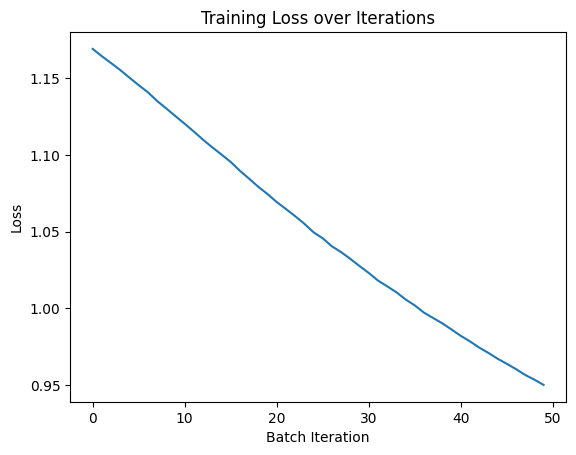

In [ ]:
import matplotlib.pyplot as plt
import torch

cpu_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in losses]

plt.plot(cpu_losses)
plt.xlabel("Batch Iteration") # Optional: Add labels for clarity
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.show() # Add plt.show() to display the plot

# for i in cpu_losses:
#   print(i)